
# H<sub>1</sub>: There exists an association between the rise in personal income rise for a country and the rise in the population of Jews in that country.

In [1]:

import pickle
import pandas as pd

# Handy list of the different types of encodings
encoding = ['latin1', 'iso8859-1', 'utf-8'][1]

def load_object(obj_name):
    pickle_path = '../../saves/pickle/' + obj_name + '.pickle'
    try:
        object = pd.read_pickle(pickle_path)
    except:
        with open(pickle_path, 'rb') as handle:
            object = pickle.load(handle)
    
    return(object)

def save_dataframes(**kwargs):
    csv_folder = '../../saves/csv/'
    for frame_name in kwargs:
        csv_path = csv_folder + frame_name + '.csv'
        kwargs[frame_name].to_csv(csv_path, sep=',', encoding=encoding, index=False)

# Classes, functions, and methods cannot be pickled
def store_objects(**kwargs):
    for obj_name in kwargs:
        if hasattr(kwargs[obj_name], '__call__'):
            raise RuntimeError('Functions cannot be pickled.')
        obj_path = '../../saves/pickle/' + str(obj_name)
        pickle_path = obj_path + '.pickle'
        if isinstance(kwargs[obj_name], pd.DataFrame):
            kwargs[obj_name].to_pickle(pickle_path)
        else:
            with open(pickle_path, 'wb') as handle:
                pickle.dump(kwargs[obj_name], handle, pickle.HIGHEST_PROTOCOL)

In [2]:

import re
import numpy as np

# Create a dataframe of the Jewish population data from
# https://en.wikipedia.org/wiki/Historical_Jewish_population_comparisons
file_path = '../../data/html/JewishPopulation.html'
jews_df = pd.read_html(file_path)[0]
numeric_columns = ['Pop1900', 'Pct1900', 'Pop1942', 'Pct1942',
                  'Pop1970', 'Pct1970', 'Pop2010', 'Pct2010']
int_columns = ['Pop1900', 'Pop1942', 'Pop1970', 'Pop2010']
float_columns = ['Pct1900', 'Pct1942', 'Pct1970', 'Pct2010']
jews_df.columns = ['Region'] + numeric_columns

def f(element):
    
    return str(element).split('[')[0]

jews_df['Region'] = jews_df['Region'].map(f)
jews_df['Pop1900'] = jews_df['Pop1900'].map(f)
num_regex = re.compile(r'[^0-9.]+')

def f(row):
    for column_name in numeric_columns:
        row[column_name] = num_regex.sub('', str(row[column_name]))
        try:
            row[column_name] = float(row[column_name])
        except Exception:
            row[column_name] = np.NaN
    
    return row
        
jews_df = jews_df.apply(f, axis=1)
jews_df.set_index(keys='Region', inplace=True)

# Create dataframes from the GapMinder data from
# http://www.gapminder.org/data/

encoding = ['latin1', 'iso8859-1', 'utf-8'][1]

income_df = pd.read_csv('../../data/csv/income_df.csv', encoding=encoding)
income_df.set_index(keys='Country', inplace=True)

population_df = pd.read_csv('../../data/csv/population_df.csv', encoding=encoding)
population_df.set_index(keys='Country', inplace=True)

In [3]:

# Regions that can't be compared directly to the income dataframe
# (basically lots of them)
jews_df.index.difference(income_df.index)

Index(['Africa', 'Americas', 'Arabia/Yemen', 'Asia',
       'Bolivia/Chile/Ecuador/Peru/Uruguay', 'Bulgaria/Turkey/Ottoman Empire',
       'Central America', 'China/Taiwan/Japan', 'Colombia/Guiana/Venezuela',
       'Europe', 'Israel', 'Norway/Sweden', 'Oceania', 'Russian Empire (Asia)',
       'Russian Empire (Europe)', 'Total', 'United Kingdom/Ireland'],
      dtype='object')

In [4]:

from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, str(a), str(b)).ratio()

#Check the closest names for typos
def check_for_typos(first_list, second_list):
    rows_list = []
    for first_item in first_list:
        max_similarity = 0.0
        max_item = first_item
        for second_item in second_list:
            this_similarity = similar(first_item, second_item)
            if this_similarity > max_similarity:
                max_similarity = this_similarity
                max_item = second_item

        # Get input row in dictionary format; key = col_name
        row_dict = {}
        row_dict['first_item'] = first_item
        row_dict['second_item'] = max_item
        row_dict['max_similarity'] = max_similarity

        rows_list.append(row_dict)

    column_list = ['first_item', 'second_item', 'max_similarity']
    name_similarities_df = pd.DataFrame(rows_list, columns=column_list)
    
    return name_similarities_df

In [5]:

# Closest regions to the countries in the income dataframe that are not paired up
name_similarities_df = check_for_typos(jews_df.index.difference(income_df.index), income_df.index)
name_similarities_df.sort_values(['max_similarity'], ascending=False).head(10)

,first_item,second_item,max_similarity
16,United Kingdom/Ireland,United Kingdom,0.777778
6,Central America,Central African Rep.,0.742857
3,Asia,Austria,0.727273
1,Americas,Algeria,0.666667
0,Africa,South Africa,0.666667
11,Norway/Sweden,Norway,0.631579
10,Israel,Ireland,0.615385
15,Total,Portugal,0.615385
2,Arabia/Yemen,Yemen,0.588235
12,Oceania,Albania,0.571429



Well, how about the countries that match?

In [6]:

# Get the intersection of the jew and income indexes
jews_df.index.intersection(income_df.index)

Index(['Austria', 'Belgium', 'Bosnia and Herzegovina', 'Denmark', 'France',
       'Germany', 'Hungary', 'Italy', 'Luxembourg', 'Netherlands', 'Poland',
       'Portugal', 'Romania', 'Serbia', 'Spain', 'Switzerland', 'India',
       'Iran', 'Algeria', 'Egypt', 'Ethiopia', 'Libya', 'Morocco',
       'South Africa', 'Tunisia', 'Argentina', 'Brazil', 'Canada', 'Mexico',
       'Suriname', 'United States', 'Australia', 'New Zealand'],
      dtype='object')


I think this is enough data to demonstrate the hypothesis

In [7]:

# Create a Jewish population dataframe with the common rows
jew_pop_df = jews_df.loc[jews_df.index.isin(jews_df.index.intersection(income_df.index).tolist()),
                         int_columns]
jew_pop_df.columns = [n[3:] for n in int_columns]
jew_pop_df.index.rename('Country', inplace=True)
jew_pop_df

,1900,1942,1970,2010
Country,,,,
Austria,191000.0,NaN,NaN,9000.0
Belgium,12000.0,60000.0,NaN,30300.0
Bosnia and Herzegovina,8213.0,NaN,NaN,500.0
Denmark,5000.0,NaN,NaN,6400.0
France,86885.0,250000.0,530000.0,483500.0
Germany,586948.0,NaN,30000.0,119000.0
Hungary,851378.0,445000.0,70000.0,48600.0
Italy,34653.0,48000.0,NaN,28400.0
Luxembourg,1200.0,NaN,NaN,600.0



Notice there are lots of missing values in the dataset above. I'm going to make two assumptions:<ol><li>
All Jews left the countries with missing 2010 values by 2010, and</li><li>
The populations of the countries with missing values changed smoothly over time.</li></ol>

In [8]:

# Assume all Jews left Algeria and Libya by 2010
jew_pop_df['2010'].fillna(0, inplace=True)

# Interpolate the rest of the missing values
jew_pop_df.columns = [pd.datetime(int(n[3:]), 1, 1) for n in int_columns]
jew_pop_df.interpolate(method='time', axis=1, inplace=True)
jew_pop_df.columns = [n[3:] for n in int_columns]
jew_pop_df

,1900,1942,1970,2010
Country,,,,
Austria,191000.0,1.215105e+05,7.518264e+04,9000.0
Belgium,12000.0,6.000000e+04,4.777059e+04,30300.0
Bosnia and Herzegovina,8213.0,5.268096e+03,3.304762e+03,500.0
Denmark,5000.0,5.534535e+03,5.890903e+03,6400.0
France,86885.0,2.500000e+05,5.300000e+05,483500.0
Germany,586948.0,2.527836e+05,3.000000e+04,119000.0
Hungary,851378.0,4.450000e+05,7.000000e+04,48600.0
Italy,34653.0,4.800000e+04,3.992941e+04,28400.0
Luxembourg,1200.0,9.709137e+02,8.181845e+02,600.0


In [9]:

# Frequency tables are kind of pointless,
# as the data has mostly unique values
jew_pop_df['1900'].value_counts().to_frame().head(5)
jew_pop_df['1942'].value_counts().to_frame().head(5)
jew_pop_df['1970'].value_counts().to_frame().head(5)
jew_pop_df['2010'].value_counts().to_frame().head(5)

,1900
5000.0,2
1200.0,2
50000.0,2
12551.0,1
103988.0,1


,1942
25607.461981,1
177197.950483,1
48000.000000,1
1200.000000,1
4000.000000,1


,1970
11219.411106,1
41613.938821,1
65000.000000,1
19345.565871,1
15763.977151,1


,2010
500.0,2
0.0,2
100.0,2
39400.0,1
30300.0,1


In [10]:

# Create a personal income dataframe with the common rows
pers_inc_df = income_df.loc[jews_df.index.intersection(income_df.index), [n[3:] for n in int_columns]]
pers_inc_df.index.rename('Country', inplace=True)
pers_inc_df

,1900,1942,1970,2010
Country,,,,
Austria,5704.0,7534.0,17865.0,42861.0
Belgium,6967.0,6157.0,18903.0,40764.0
Bosnia and Herzegovina,1072.0,1233.0,2500.0,9145.0
Denmark,5566.0,8095.0,21990.0,42997.0
France,4314.0,4700.0,18185.0,36745.0
Germany,4596.0,10407.0,21218.0,40632.0
Hungary,2863.0,6199.0,12917.0,22062.0
Italy,3528.0,6403.0,16450.0,35753.0
Luxembourg,3751.0,13698.0,29363.0,91147.0


In [11]:

# Frequency tables are kind of pointless,
# as the data has mostly unique values
pers_inc_df['1900'].value_counts().to_frame().head(5)
pers_inc_df['1942'].value_counts().to_frame().head(5)
pers_inc_df['1970'].value_counts().to_frame().head(5)
pers_inc_df['2010'].value_counts().to_frame().head(5)

,1900
6819.0,1
2806.0,1
1072.0,1
4314.0,1
4596.0,1


,1942
10407.0,1
2214.0,1
1233.0,1
4700.0,1
2978.0,1


,1970
18903.0,1
8705.0,1
1170.0,1
3055.0,1
778.0,1


,2010
54183.0,1
40773.0,1
21328.0,1
1081.0,1
31824.0,1


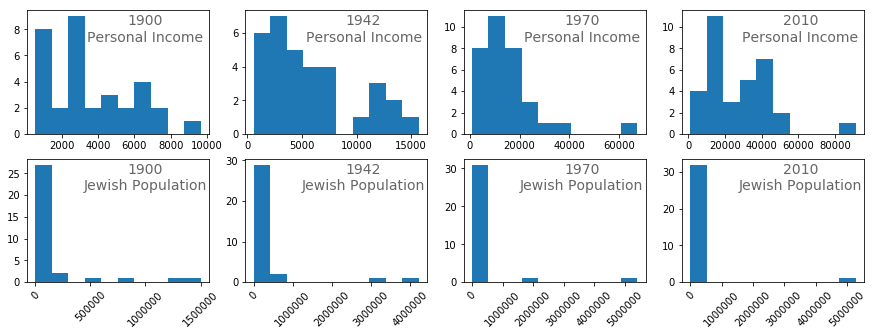

In [12]:

# Histograms are better
%matplotlib inline
import matplotlib.pyplot as plt

# Use the following only if you are on a high definition device
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')


fig = plt.figure(figsize=(15, 5))
num_rows = 2
num_cols = 4
i = 1
for row_num, df in enumerate([pers_inc_df, jew_pop_df]):
    for col_num, col_name in enumerate([n[3:] for n in int_columns]):
        ax = fig.add_subplot(num_rows, num_cols, i, autoscale_on=True)
        i += 1
        note_text = col_name
        if row_num > 0:
            xrot = 45
            note_text += '\nJewish Population'
        else:
            xrot = 0
            note_text += '\nPersonal Income'
        note = ax.text(0.65, 0.97, note_text, transform=ax.transAxes, fontsize=14,
                       fontweight='normal', va='top', ha='center', alpha=.6)
        histogram = df[col_name].hist(ax=ax, grid=False, bins=10, xrot=xrot)


## Summary

In 1900, personal income was less than \$10,000 per person everywhere in the select countries. The Jewish population, though mostly close to zero for the select countries, had 6 or so countries where the population was substantial, evenly spread up to a population of 1.5 million in one country (the US). As the years progressed, personal income vastly increased (from \$10K to \$15K to over \$60K to well over \$80K) and a large gap started forming between the top country and the rest of the select countries. Similarly, as the years progressed, Jewish population slightly increased (from 1.5M to 4M to 5M) and a large gap started forming as most of the middle values disappeared, leaving most of the Jewish population in one country with a small population in a large number of the select countries.

In [13]:

save_dataframes(pers_inc_df=pers_inc_df, jew_pop_df=jew_pop_df)
data_df = jew_pop_df.join(pers_inc_df, lsuffix='_jew_pop', rsuffix='_pers_inc')
data_df = data_df.applymap(lambda x: int(x))
save_dataframes(data_df=data_df)
store_objects(data_df=data_df)
data_df

,1900_jew_pop,1942_jew_pop,1970_jew_pop,2010_jew_pop,1900_pers_inc,1942_pers_inc,1970_pers_inc,2010_pers_inc
Country,,,,,,,,
Austria,191000,121510,75182,9000,5704,7534,17865,42861
Belgium,12000,60000,47770,30300,6967,6157,18903,40764
Bosnia and Herzegovina,8213,5268,3304,500,1072,1233,2500,9145
Denmark,5000,5534,5890,6400,5566,8095,21990,42997
France,86885,250000,530000,483500,4314,4700,18185,36745
Germany,586948,252783,30000,119000,4596,10407,21218,40632
Hungary,851378,445000,70000,48600,2863,6199,12917,22062
Italy,34653,48000,39929,28400,3528,6403,16450,35753
Luxembourg,1200,970,818,600,3751,13698,29363,91147


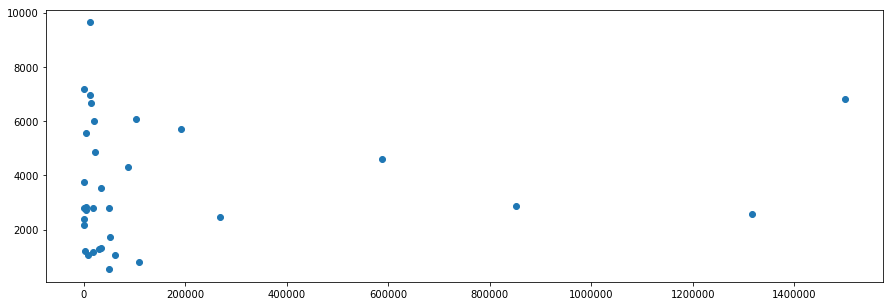

In [16]:

%matplotlib inline
import matplotlib.pyplot as plt

# Use the following only if you are on a high definition device
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')


fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111, autoscale_on=True)
x = data_df['1900_jew_pop']
y = data_df['1900_pers_inc']
dots = ax.scatter(x, y)

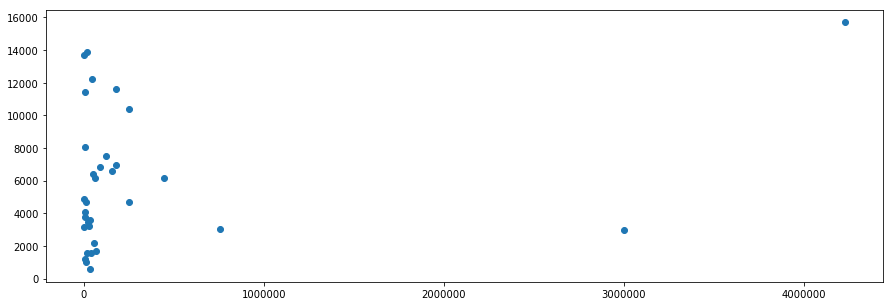

In [18]:

%matplotlib inline
import matplotlib.pyplot as plt

# Use the following only if you are on a high definition device
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')


fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111, autoscale_on=True)
x = data_df['1942_jew_pop']
y = data_df['1942_pers_inc']
dots = ax.scatter(x, y)

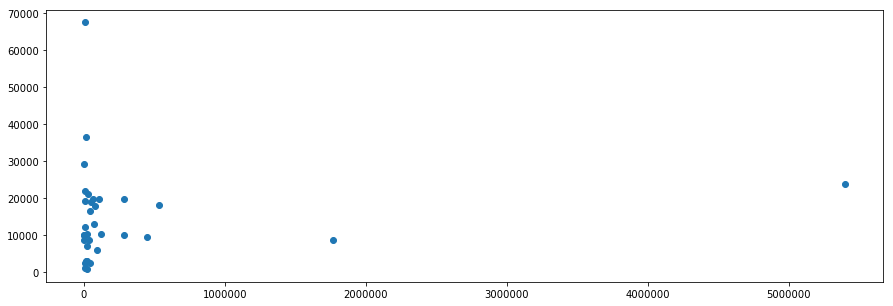

In [19]:

%matplotlib inline
import matplotlib.pyplot as plt

# Use the following only if you are on a high definition device
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')


fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111, autoscale_on=True)
x = data_df['1970_jew_pop']
y = data_df['1970_pers_inc']
dots = ax.scatter(x, y)

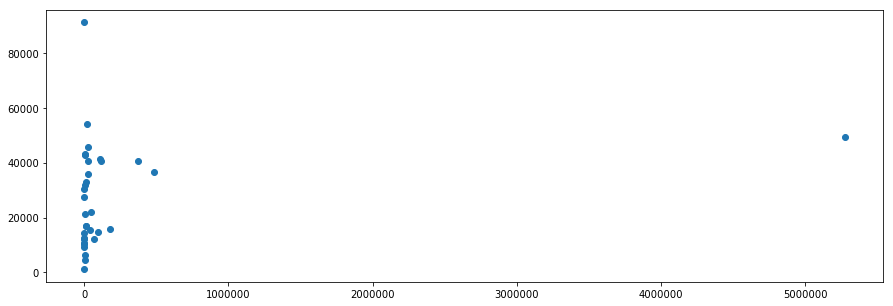

In [20]:

%matplotlib inline
import matplotlib.pyplot as plt

# Use the following only if you are on a high definition device
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')


fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111, autoscale_on=True)
x = data_df['2010_jew_pop']
y = data_df['2010_pers_inc']
dots = ax.scatter(x, y)

Country
Luxembourg               -47925.205289
Portugal                  -2474.345246
Denmark                   -1537.486846
Suriname                   -634.791281
Switzerland                -130.175817
New Zealand                 -46.227980
Libya                       -25.365076
Serbia                      -23.612054
Italy                       -14.976870
Spain                       -11.356662
South Africa                 -8.635626
United States                -6.736970
India                        -4.494938
Iran                         -4.454210
Netherlands                  -3.871481
Bosnia and Herzegovina       -3.503249
France                       -3.102373
Argentina                    -2.723588
Canada                       -2.069449
Poland                       -2.004145
Brazil                       -1.948525
Belgium                      -1.943495
Morocco                      -1.937680
Austria                      -1.934420
Tunisia                      -1.819965
Romania          

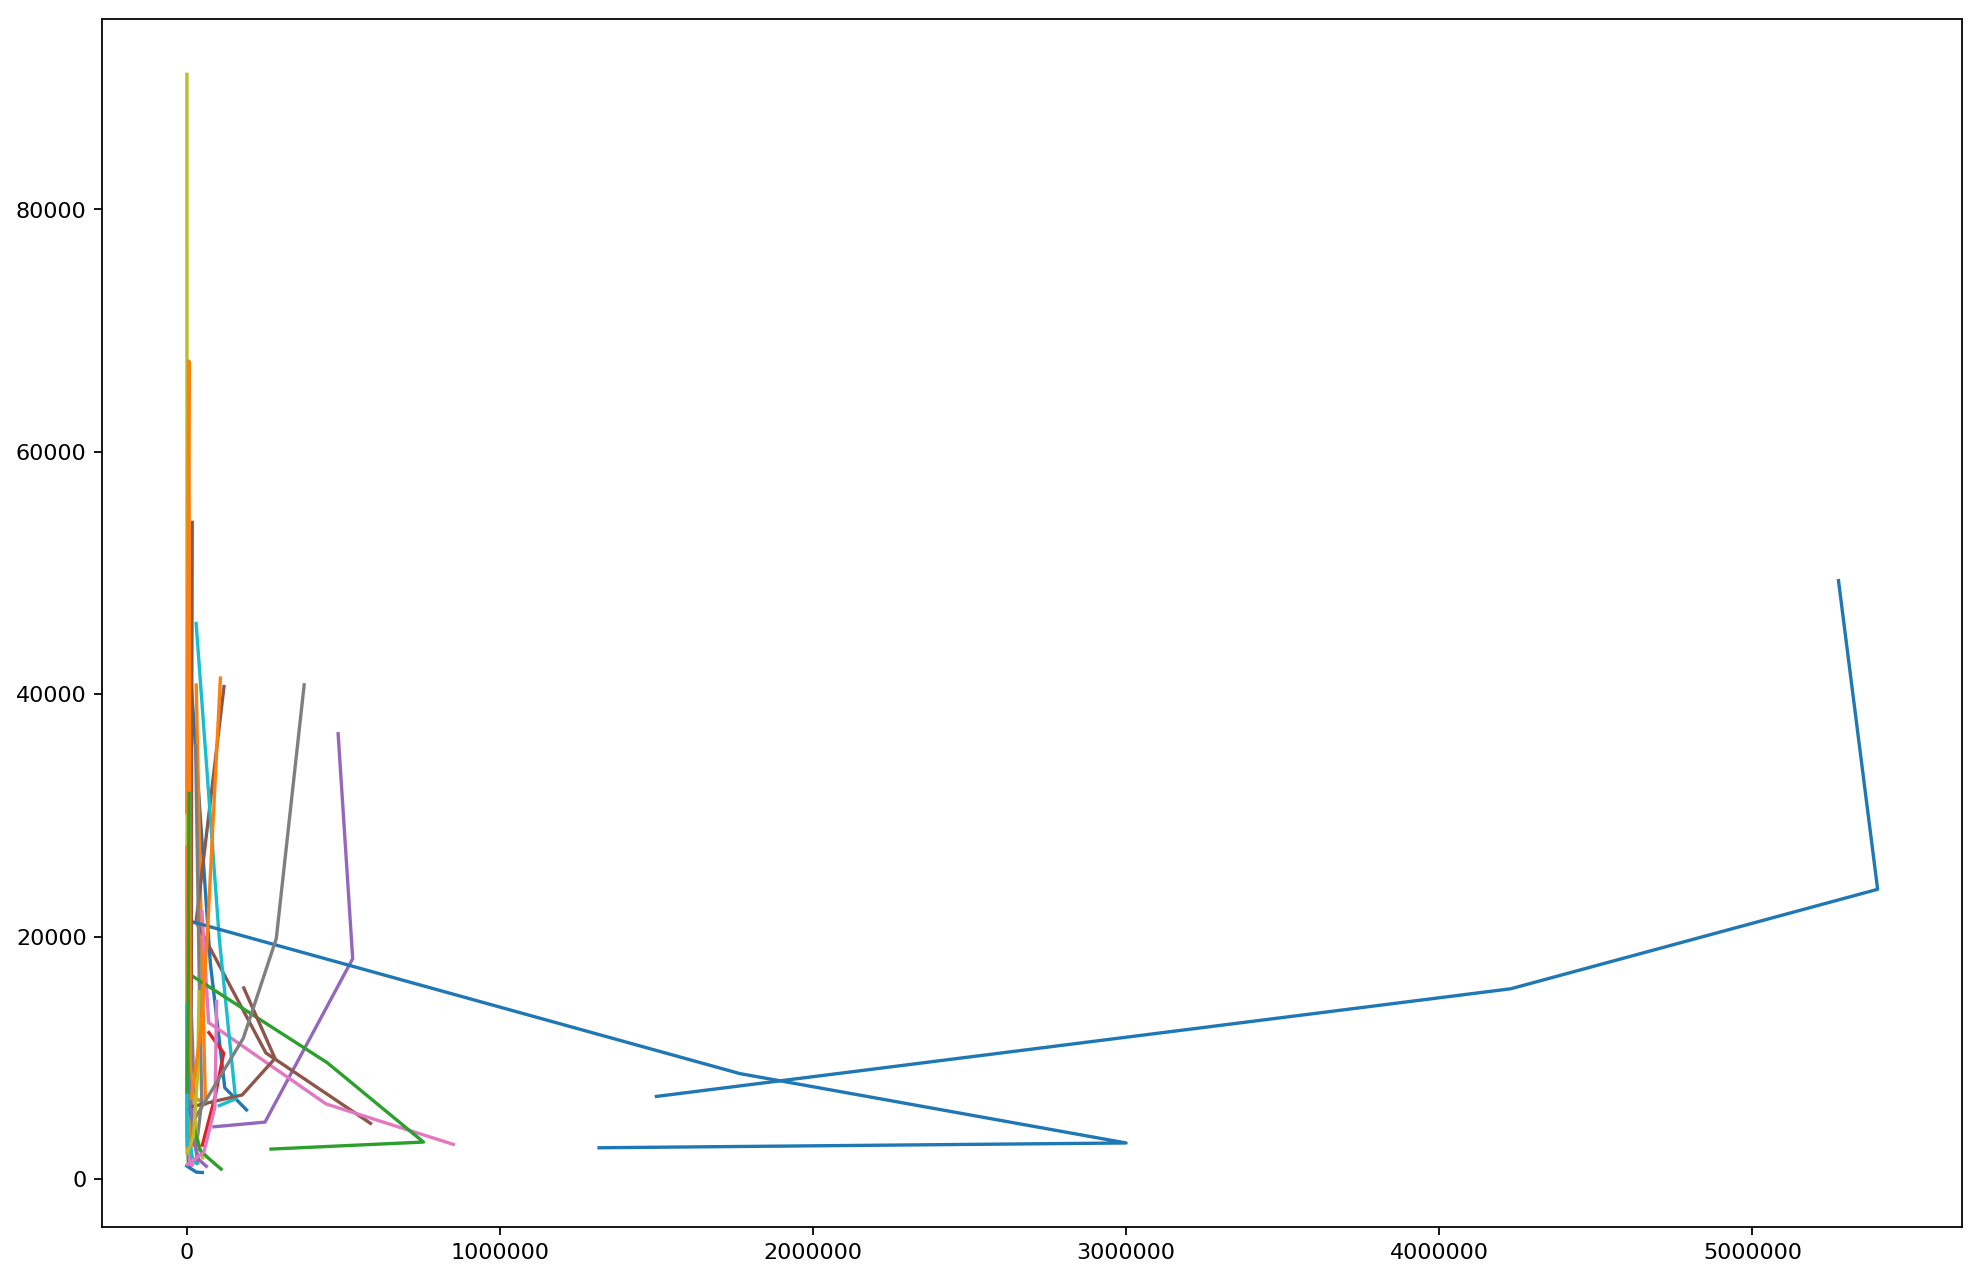

In [29]:

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Use the following only if you are on a high definition device
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def f(row):
    y_jew_pop = [row['1900_jew_pop'], row['1942_jew_pop'], row['1970_jew_pop'], row['2010_jew_pop']]
    y_pers_inc = [row['1900_pers_inc'], row['1942_pers_inc'], row['1970_pers_inc'], row['2010_pers_inc']]
    lines = ax.plot(row[jew_pop_columns], row[pers_inc_columns], label=row.index)
    
    return r2_score(y_jew_pop, y_pers_inc)

fig = plt.figure(figsize=(15, 10), dpi=80)
ax = fig.add_subplot(111, autoscale_on=True)
data_df['coefficient_of_dermination'] = data_df.apply(f, axis=1)
data_df.sort_values('coefficient_of_dermination')['coefficient_of_dermination']


All of these coefficients of determination are negative, therefore there is a _negative_ association.